In [3]:
## For data handling
import pandas as pd
import numpy as np

## For plotting
import matplotlib.pyplot as plt
from seaborn import set_style
import seaborn as sns
## This sets the plot style
## to have a grid on a white background
set_style("white")

#For machine learning methods
from sklearn.model_selection import train_test_split

#For neural network
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img

## Importing the things
from keras import models
from keras import layers
from keras import optimizers
from keras import losses
from keras import metrics
from keras.utils import to_categorical
import json

import skimage
print(skimage.__version__)

import warnings
warnings.filterwarnings('ignore')

## Checks what is tensorflow running on
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

## This imports datasets stored in keras
from keras.datasets import mnist

0.19.2
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15230518496007279840
xla_global_id: -1
]


# Sample of size 15,000 and 100 labels


# Data preprocessing 
- Here I have a new dataset for training. In this case, I have selected 100 randomly chosen bird species out of 400 in total. The selected labels are used for running a query in the original $\rm{birds_{db}}$ database to collect all images and data points correspoinding to these 100 labels, in total $15694$ data points or observations. Since these labels were randomly selected the numerical indices are not orderly unlike the entire dataset. This causes a problem with the output neron layer in the Conv Net architecture, with many of the images having unclassified labels. So I have assigned new numerical labels $0 - 99$ to each image. This way we can use tensorflow method to_categorical to convert the digits to $[1,0,0,..0]$ format compatible with softmax probability output.    

In [4]:
birds_db = pd.read_csv('./birds_archive/birds.csv')
birds_db.value_counts('labels')
birds_class = pd.read_csv('./birds_archive/class_dict.csv')
birds_names = pd.read_csv('./birds_archive/birds latin names.csv')

print(birds_names.head(2))
print('..................................\n')
print(birds_class.head(2))
print('..................................\n')
(birds_db.tail())
#birds_db.loc[birds_db.labels=='ABBOTTS BABBLER']
#birds_db.value_counts('labels')

   class_index            class       SCIENTIFIC NAME
0            0  ABBOTTS BABBLER  Malacocincla abbotti
1            1    ABBOTTS BOOBY      Papasula abbotti
..................................

   class_index            class  height  width  scale by  Offset
0            0  ABBOTTS BABBLER     112    112         1       0
1            1    ABBOTTS BOOBY     112    112         1       0
..................................



,class index,filepaths,labels,data set
62383,399,valid/YELLOW HEADED BLACKBIRD/1.jpg,YELLOW HEADED BLACKBIRD,valid
62384,399,valid/YELLOW HEADED BLACKBIRD/2.jpg,YELLOW HEADED BLACKBIRD,valid
62385,399,valid/YELLOW HEADED BLACKBIRD/3.jpg,YELLOW HEADED BLACKBIRD,valid
62386,399,valid/YELLOW HEADED BLACKBIRD/4.jpg,YELLOW HEADED BLACKBIRD,valid
62387,399,valid/YELLOW HEADED BLACKBIRD/5.jpg,YELLOW HEADED BLACKBIRD,valid


In [5]:
birds_names_subset = birds_names.sample(100, random_state=42)
birds_names_subset = birds_names_subset.rename(columns={'class':'labels'})
print(birds_names_subset)

birds_db_subset = birds_db[birds_db['labels'].isin(birds_names_subset['labels'])].dropna()
birds_db_subset = birds_db_subset.reset_index()
birds_db_subset

#pd.DataFrame(pd.Series(label_dict, index=label_dict.keys()))
label_dict = {i:birds_names_subset['labels'].values[i] for i in range(len(birds_names_subset))}
labelsDF = pd.DataFrame(label_dict.items(), columns=['label_index','label'])


     class_index               labels         SCIENTIFIC NAME
209          209      HARLEQUIN QUAIL    Coturnix delegorguei
280          280    NORTHERN SHOVELER        Spatula clypeata
33            33             AVADAVAT       Amandava amandava
210          210          HARPY EAGLE          Harpia harpyja
93            93        CAPE LONGCLAW       Macronyx capensis
..           ...                  ...                     ...
314          314    RED FACED WARBLER   Cardellina rubrifrons
373          373    TROPICAL KINGBIRD  Tyrannus melancholicus
380          380  VERMILION FLYCATHER   Pyrocephalus obscurus
239          239           JACK SNIPE    Lymnocryptes minimus
75            75           BLUE HERON          Ardea herodias

[100 rows x 3 columns]


In [6]:
%%time 
# this piece loads image data into a list and a numpy array 
bird_labels = []
bird_label_num = []
birdImage_list_jpg = []
birdImage_list = []

for indx, filepath, label in zip(range(len(birds_db_subset)), birds_db_subset.filepaths, birds_db_subset.labels):
    try:
        bird_labels.append(label)
        bird_label_num.append(labelsDF.loc[labelsDF['label'] == label, 'label_index'].values[0])
        #print(filepath)
        img = tf.keras.utils.load_img(
                './birds_archive/Data/'+filepath,
                grayscale=False,
                color_mode='rgb',
                target_size=None,
                interpolation='nearest',
                keep_aspect_ratio=False)
        
        # list of bird images in jpg format 
        birdImage_list_jpg.append(img)  
        
        img_arr = np.array(img)
        # List containng all bird images each in array format 
        birdImage_list.append(img_arr)
    except (TypeError, IndexError) as e:
        pass
        #print(indx, label)

# Numpy array N x 224x224x3 containing all bird images 
birdImage_arr = np.array(birdImage_list) 

X_train, X_val, y_train, y_val = train_test_split(birdImage_arr, (pd.DataFrame(bird_label_num)[0]).values,
                                                                          test_size=0.15, shuffle=True, random_state=44)
X_train = X_train / 255
X_val = X_val / 255
print(X_train.shape)
print()
print(X_val.shape)

(13339, 224, 224, 3)

(2355, 224, 224, 3)
CPU times: total: 28 s
Wall time: 28.4 s


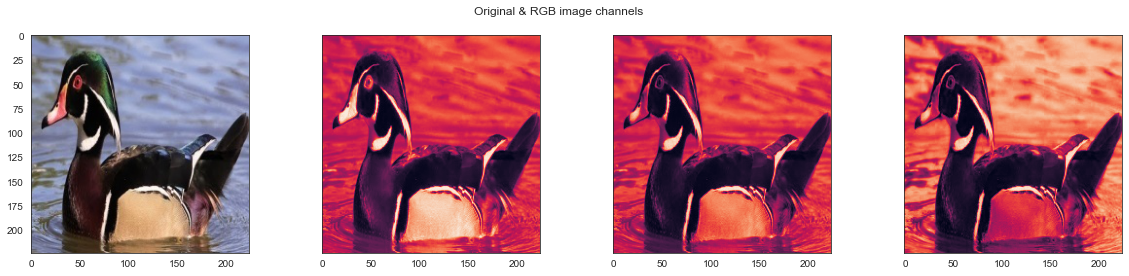

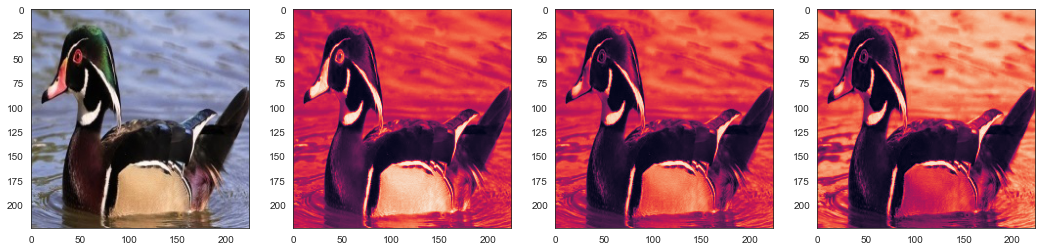

In [7]:
img = tf.keras.utils.load_img(
                './birds_archive/Data/'+filepath,
                grayscale=False,
                color_mode='rgb',
                target_size=None,
                interpolation='nearest',
                keep_aspect_ratio=False)


i, (im1, im2, im3, im4) = plt.subplots(1, 4, sharey=True)
i.set_figwidth(20) 
im1.imshow(img)  #Original image
im2.imshow(np.array(img)[:, : , 0]) #Red
im3.imshow(np.array(img)[:, : , 1]) #Green
im4.imshow(np.array(img)[:, : , 2]) #Blue
i.suptitle('Original & RGB image channels')

fig,ax = plt.subplots(1,4,figsize=(18,18))
ax[0].imshow(np.array(img)[:, : , :])
ax[1].imshow(np.array(img)[:, : , 0])
ax[2].imshow(np.array(img)[:, : , 1])
ax[3].imshow(np.array(img)[:, : , 2])
plt.show()
plt.close()

In [8]:
X_train.shape, to_categorical(y_train).shape, X_val.shape, to_categorical(y_val).shape, #n_species

((13339, 224, 224, 3), (13339, 100), (2355, 224, 224, 3), (2355, 100))

# Convolutional Neural Network: architecture 2
- This is baseline model built on two fundamental principles of computer vision:  $\textbf{1. Translational invariance}$ and $\textbf{2. Spatial hiararchy}$. This is a simple model with a few  convolutional (invariance) and pooling (hiararchy) layers. The depth values are chosen based on the complexity of input feature space as well as the number of softmax output neurons. Fiiters and other parameters are kept standard.   


In [1]:
from keras.regularizers import l2 

modelB = models.Sequential()
n_species = to_categorical(y_train).shape[1]
# Add convolutional layer
#model.add( layers.Conv3D(32, (3,3,3), activation='relu', input_shape=(224,224,3,1)) )
modelB.add( tf.keras.layers.Conv2D(64, 3, activation='relu', input_shape=(224,224, 3)))
modelB.add( layers.MaxPool2D((2,2), strides=2) ) 
# more layers 
modelB.add( layers.Conv2D(64, (3,3), activation='relu') )
modelB.add( layers.MaxPool2D((2,2), strides=2))
modelB.add( layers.Conv2D(128, (3,3), activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)) )

modelB.add( layers.MaxPool2D((2,2), strides=2))
modelB.add( layers.Conv2D(128, (3,3), activation='relu',kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) 

# .Flatten() will flatten the data for us
modelB.add(layers.Flatten())
modelB.add(layers.Dropout(.5))

## # Now we'll add the fully connected layer >>> feedforward
modelB.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)) )
modelB.add(layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
## Finally an output layer
modelB.add(layers.Dense(n_species, activation='softmax'))

modelB.summary()

NameError: name 'models' is not defined

In [1]:
# OPTIONAL 

from keras.models import load_model

modelB = load_model('convNet_birds_baseline.h5')
modelB.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 64)      1792      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 111, 111, 64)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 64)      36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 26, 26, 128)     

# ConvNet Training - sample of size 15,000 and 100 labels

In [ ]:
%%time
# Compile the model 

modelB.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)
## First make the validation set

# ## Fit the model, and store the training history
## using 100 epochs and a batch_size of 512
n_epoch= 5
historyB = modelB.fit(X_train, to_categorical(y_train), epochs=n_epoch, batch_size=512,
                   validation_data=(X_val, to_categorical(y_val)), callbacks=[callback], verbose=1)

historyB_dict = historyB.history
print(historyB_dict.keys())

modelB.save("convNet_birds_baseline_regTemp.h5")
print("Saved model to disk")

Epoch 1/5


In [19]:
modelB.save("convNet_birds_baseline_reg.h5")
print("Saved model to disk")

Saved model to disk


In [13]:
# run ONLY once
valB_accuracy = []
trainB_accuracy = []

# Model performance 

In [27]:
for tr, val, loss in zip(historyB_dict['accuracy'], historyB_dict['val_accuracy'], historyB_dict['val_loss']): 
    trainB_accuracy.append(tr)
    valB_accuracy.append(val)
    
with open("train_accuracy", "w") as fp:
    json.dump(trainB_accuracy, fp)

with open("validation_accuracy", "w") as fp:
    json.dump(valB_accuracy, fp)

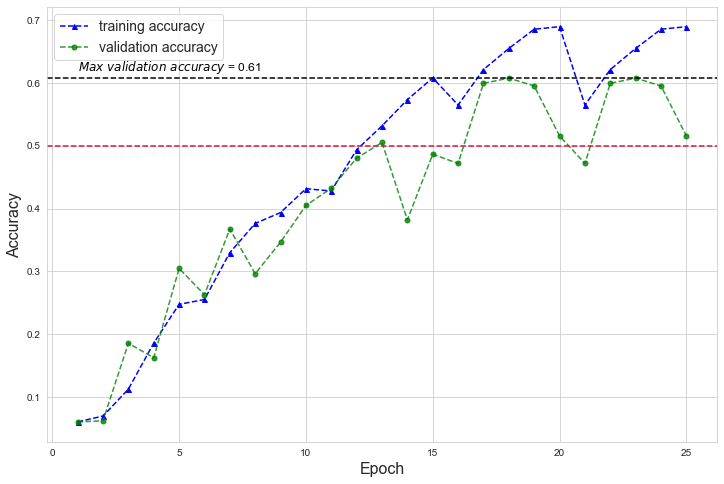

15/15 [==============================] - 3s 198ms/step


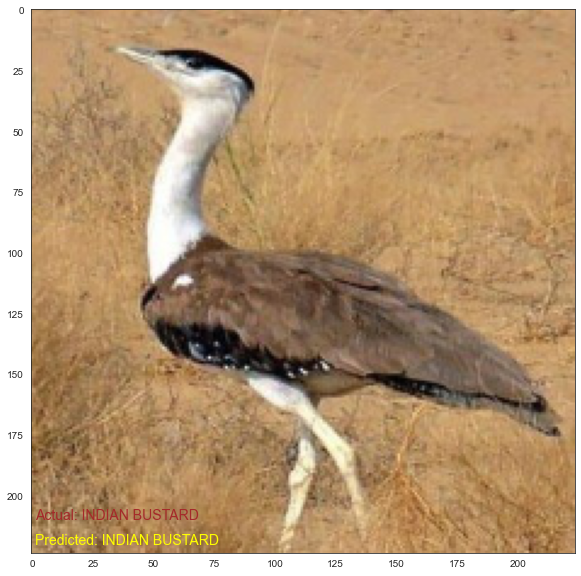

In [28]:
with open("train_accuracy", "r") as fp:
    trainB_accuracy = json.load(fp)   
with open("validation_accuracy", "r") as fp:
    valB_accuracy = json.load(fp)
    
N = len(valB_accuracy) #n_epoch-1
# Display the metrics
set_style("whitegrid")
plt.figure(figsize=(12,8))
plt.plot(range(1,N+1), trainB_accuracy,'b--^', markersize=5,label='training accuracy')
plt.plot(range(1,N+1), valB_accuracy,'g--o', markersize=5, alpha=0.8, label='validation accuracy')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)

plt.axhline(y=0.5, color='crimson', ls='--', alpha=1)
plt.axhline(y=np.array(valB_accuracy).max(), color='k', ls='--')

plt.text(1,np.round(np.array(valB_accuracy).max(),2)+0.01, 
         '$Max ~validation ~ accuracy$ = ' +str(np.round(np.array(valB_accuracy).max(),2)), 
         color='k', fontsize=12 )


plt.legend(fontsize=14)
#plt.savefig('perfomance_convNetBaseline_reg.pdf')
plt.show()
plt.close()

set_style("white")
# Prediction power
n=np.random.binomial(100,0.5,1)[0]
predicted_bird = modelB.predict(X_val)[n].argmax()
actual_bird = y_val[n]

plt.figure(figsize=(10,10))
plt.imshow(X_val[n], cmap='gray')
plt.text(1,220, 'Predicted: ' + str(labelsDF.loc[labelsDF['label_index'] == predicted_bird, 'label'].values[0]),
         color='yellow', fontsize=14 )

plt.text(1,210, 'Actual: ' + str(labelsDF.loc[labelsDF['label_index'] == actual_bird, 'label'].values[0]),
         color='brown', fontsize=14 )


plt.show()
plt.close()